# More DNNs
John Ignacio R.M. 2020-05-18

In [64]:
import pandas as pd
from glob import glob
ada_parent_dir = "../"
import sys
sys.path.append(ada_parent_dir)
import ada
import matplotlib.pyplot as plt
import numpy as np

from keras import Model
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import sgd, adam, adagrad, adadelta
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix
from keras.models import model_from_json

## Data Processing

In [2]:
data_path = "../processed_data/"
signal = "Xtohh"

In [3]:
#import datasets and drop twodim region
data = {path.split('/')[-1][:-4]: ada.drop_twodim(pd.read_csv(path)) for path in glob(data_path + signal + "[0-9]*.csv")}

In [4]:
#filter region and tag
data = {sign_name: ada.filter_tag(ada.filter_region(sign_df, "SR"), 1) for sign_name, sign_df in data.items()}

In [5]:
#classify (label)
data = {sign_name: ada.classify_events(sign_df, sign_name, "label") for sign_name, sign_df in data.items()}

In [6]:
#join all datasets
df = pd.concat(data)
df.index.names = ["dataset", None]
df.reset_index(level=[0], inplace = True)

In [7]:
#showing signal distribution
distri = ada.signal_distribution_per(df, ["dataset"], signal_col = "label")
distri

,signal w-density,signal density,signal count,total count
dataset,,,,
Xtohh1000,0.043697,0.401192,2154.0,5369.0
Xtohh1200,0.177675,0.609309,5014.0,8229.0
Xtohh1400,0.265908,0.716815,8138.0,11353.0
Xtohh1600,0.317951,0.760682,10219.0,13434.0
Xtohh1800,0.345857,0.781099,11472.0,14687.0
Xtohh2000,0.358223,0.787971,11948.0,15163.0
Xtohh2500,0.331801,0.764641,10445.0,13660.0
Xtohh3000,0.250274,0.680322,6842.0,10057.0


This time we are going to train with the **Xtohh2000 dataset**, that has 80% of signal events.

In [8]:
X2000 = data["Xtohh2000"]
X2000

,sample,EventWeightNoXSec,EventWeight,EventNumber,m_region,m_FJNbtagJets,m_AntiBTag,m_AntiTauTag,m_FJpt,m_FJeta,...,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt,m_hhm_Coll,m_hhm_Eff,m_hhm_ConEff,m_hhm_ConVis,label
1,Xtohh2000_Hw,0.007521,0.000924,45720,SR,1,2,0,712.04987,0.777979,...,3.562367,0.100524,191.302860,1460.4628,362.497900,-999.0,1687.0303,1088.1353,2005.2303,1
3,Xtohh2000_Hw,0.009777,0.001201,48105,SR,1,3,0,811.50574,0.572188,...,3.270177,-0.372708,52.183260,1810.2671,76.732270,-999.0,1862.9153,1577.6603,1881.0702,1
4,Xtohh2000_Hw,0.007615,0.000936,43016,SR,1,3,0,515.09570,-1.187085,...,3.782085,-0.031341,155.676510,1573.5206,83.307240,-999.0,1731.4364,1151.4961,2059.8613,1
6,Xtohh2000_Hw,0.007994,0.000982,44414,SR,1,2,0,825.25050,0.555025,...,3.268556,0.047143,41.337784,1774.2710,52.035880,-999.0,1816.6096,1791.3428,1899.1582,1
7,Xtohh2000_Hw,0.010229,0.001257,49661,SR,1,4,0,516.90210,1.204237,...,4.126717,0.669538,60.221653,2240.3710,39.758583,-999.0,2300.5159,1390.9546,2578.0103,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81474,Zcc,1.205571,0.006003,3773861,SR,1,4,0,722.11290,-0.234110,...,3.164140,-0.208536,58.145126,1221.5391,272.812620,-999.0,1291.4500,1433.9529,1677.5961,0
81486,Zbb,0.929995,0.004631,3775118,SR,1,2,0,659.31750,-0.498314,...,3.285652,0.439522,84.458730,1422.1833,117.770500,-999.0,1509.8374,1298.5731,1963.6682,0
81496,Zl,1.532080,0.007629,3780998,SR,1,3,0,1155.48910,-0.049598,...,2.733104,-0.130584,228.010350,1671.0092,654.887300,-999.0,1947.7340,1624.8837,2325.8188,0
81500,Zbl,0.897816,0.004471,3781886,SR,1,4,0,537.75476,-0.575373,...,2.559346,0.009155,156.438670,826.6153,336.893100,-999.0,1037.8660,714.7258,966.7310,0


In [9]:
#features have being selected by the domain expert
selected_features = ['m_FJpt', 'm_FJeta', 'm_FJphi', 'm_FJm', 'm_DTpt', 'm_DTeta', 'm_DTphi', 'm_DTm',
'm_dPhiFTwDT', 'm_dRFJwDT', 'm_dPhiDTwMET', 'm_MET', 'm_hhm', 'm_bbttpt', "label"]

In [10]:
#filtering
X2000 = X2000[["EventWeight"] + selected_features]
X2000

,EventWeight,m_FJpt,m_FJeta,m_FJphi,m_FJm,m_DTpt,m_DTeta,m_DTphi,m_DTm,m_dPhiFTwDT,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt,label
1,0.000924,712.04987,0.777979,-1.545740,110815.440,352.04910,-1.051462,1.510991,66249.040,3.056731,3.562367,0.100524,191.302860,1460.4628,362.497900,1
3,0.001201,811.50574,0.572188,-2.850629,104430.520,749.68250,-0.517416,0.349243,115776.445,3.083314,3.270177,-0.372708,52.183260,1810.2671,76.732270,1
4,0.000936,515.09570,-1.187085,-0.599296,103066.414,434.88837,0.988049,2.589869,72923.710,3.094020,3.782085,-0.031341,155.676510,1573.5206,83.307240,1
6,0.000982,825.25050,0.555025,-2.598408,77778.470,773.21750,-0.349498,0.542499,109134.120,3.140907,3.268556,0.047143,41.337784,1774.2710,52.035880,1
7,0.001257,516.90210,1.204237,-1.797073,183877.950,548.83075,-1.522980,1.389005,94300.130,3.097108,4.126717,0.669538,60.221653,2240.3710,39.758583,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81474,0.006003,722.11290,-0.234110,0.342838,166048.060,450.34055,0.400473,-2.757015,65868.710,3.099853,3.164140,-0.208536,58.145126,1221.5391,272.812620,0
81486,0.004631,659.31750,-0.498314,0.609688,263739.840,543.51630,0.573946,-2.567734,64603.945,3.105763,3.285652,0.439522,84.458730,1422.1833,117.770500,0
81496,0.007629,1155.48910,-0.049598,1.159050,46282.180,608.55176,-0.414142,-1.549633,64589.440,2.708683,2.733104,-0.130584,228.010350,1671.0092,654.887300,0
81500,0.004471,537.75476,-0.575373,-0.764079,106766.016,312.78960,-1.021361,1.756109,91392.360,2.520188,2.559346,0.009155,156.438670,826.6153,336.893100,0


In [11]:
#X and y sets
df_X = X2000.drop(columns = ["label"])
df_y = X2000["label"]

In [12]:
#split dataset
X_train, X_val, X_test, y_train, y_val, y_test, w_train, w_val, w_test = ada.train_val_test_split(
    df_X,
    df_y,
    0.6, #train
    0.2, #val
    0.2, #test
    seed = 1
)

In [13]:
X_train

,m_FJpt,m_FJeta,m_FJphi,m_FJm,m_DTpt,m_DTeta,m_DTphi,m_DTm,m_dPhiFTwDT,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt
28757,785.60720,-0.906344,-2.864651,127661.875,366.51950,1.175110,0.438245,76462.410,2.980289,3.635186,0.179581,205.715240,1718.7709,427.91367
17244,1003.88916,-0.438111,1.169513,117035.530,483.04648,-0.590374,-2.068076,59796.523,3.045596,3.049400,-0.107614,547.200900,1406.3322,525.11180
47979,492.29570,1.536342,-2.229996,127920.850,338.53660,-1.679215,0.893351,73215.555,3.123347,4.482757,-0.721842,41.455402,2129.3286,153.93939
19896,860.60890,-0.321908,-1.781790,33333.695,520.31580,0.333560,1.406105,65643.190,3.095291,3.163932,0.148632,329.742520,1415.1832,341.70050
19031,858.74180,-0.027310,-0.985247,140746.840,779.65030,-1.036928,2.269363,104057.540,3.028576,3.192429,-0.287529,85.686790,1865.0897,121.64710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22399,915.46110,0.883723,0.346661,51626.805,529.42950,0.315619,-2.903772,69863.805,3.032752,3.085503,0.011956,478.322630,1453.8452,393.39075
49050,611.87177,-1.851003,-1.984845,51283.387,648.28595,0.767006,1.480086,71201.020,2.818254,3.846625,-0.186754,96.601990,2497.9119,206.00159
14326,919.30480,-0.268462,1.356605,101131.510,307.06020,-1.114988,-1.478989,45312.547,2.835594,2.959257,0.076207,531.400600,1157.2285,633.30035
6239,642.92816,-0.725761,-0.332452,103132.234,494.51230,0.421602,2.607750,63133.207,2.940203,3.156142,0.032920,307.048200,1324.0441,186.75813


In [14]:
#standarize
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val),columns=X_val.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

In [15]:
#reshape ys and ws
y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

w_train = w_train.values
w_val = w_val.values
w_test = w_test.values

In [16]:
#number of events and features
n_train_events, n_features = X_train.shape
n_train_events, n_features

(9097, 14)

## Weighted DNN

In [17]:
epochs = 50

In [18]:
class KerasModel:

    def __init__(self, n_input):
        self.model = None
        self.training = None
        self.title = ""
    
    def fit(self, X_train, y_train, w_train, X_val, y_val, w_val, epochs):
        if self.model != None:
            self.training = self.model.fit(
                X_train.values,
                y_train,
                sample_weight = w_train,
                epochs = epochs,
                verbose = 1,
                validation_data = (
                    X_val.values,
                    y_val,
                    w_val
                )
            )
        else:
            print("Build your model first!")
    
    def plot_training(self, width = 10, height = 6):
        #data
        train_loss = self.training.history['loss']
        val_loss = self.training.history['val_loss']
        epochs = len(train_loss)
        #plot
        plt.figure(1, figsize=(width, height))
        plt.plot(range(epochs), train_loss)
        plt.plot(range(epochs), val_loss)
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.title("Training vs Validation Loss " + self.title)
        plt.grid(True)
        plt.legend(['Training', 'Validation'])
        plt.show()
    
    def summary(self):
        self.model.summary()
    
    def evaluate(self, X_test, y_test, w_test):
        y_pred = self.model.predict(X_test, batch_size=64, verbose=1)
        y_pred_bool = np.argmax(y_pred, axis=1)
        return classification_report(y_test, y_pred_bool)

In [19]:
#weighted neural network v1
class WNN_v1(KerasModel):

    def __init__(self, n_input):
        #model
        self.model = Sequential()
        #input
        self.model.add(Dense(128, input_dim = n_input, kernel_initializer='uniform',activation='relu'))
        #hidden layers
        self.model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
        self.model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
        self.model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
        #compile
        self.model.compile(optimizer=adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])

        #title
        self.title = 'optimizer: adam , lr = 0.01, loss = binary cossentropy)'

        #training
        self.training = None

In [20]:
modelv1 = WNN_v1(n_features)

2020-05-19 22:52:43.590677: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-19 22:52:43.745478: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2020-05-19 22:52:43.745587: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: valkyrie
2020-05-19 22:52:43.745613: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: valkyrie
2020-05-19 22:52:43.764858: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 440.64.0
2020-05-19 22:52:43.765041: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 440.64.0
2020-05-19 22:52:43.765073: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 440.64.0
2020-05-19 22:52:43.766184: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU

In [21]:
modelv1.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1920      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 35,073
Trainable params: 35,073
Non-trainable params: 0
_________________________________________________________________


In [22]:
modelv1.fit(X_train_scaled, y_train, w_train, X_val_scaled, y_val, w_val, epochs)

Train on 9097 samples, validate on 3033 samples
Epoch 1/50
9097/9097 [==============================] - 1s 116us/step - loss: 0.0013 - accuracy: 0.8114 - val_loss: 0.0011 - val_accuracy: 0.7867
Epoch 2/50
9097/9097 [==============================] - 1s 63us/step - loss: 0.0012 - accuracy: 0.8276 - val_loss: 0.0011 - val_accuracy: 0.7705
Epoch 3/50
9097/9097 [==============================] - 1s 55us/step - loss: 0.0010 - accuracy: 0.7947 - val_loss: 9.8726e-04 - val_accuracy: 0.8091
Epoch 4/50
9097/9097 [==============================] - 0s 50us/step - loss: 9.2795e-04 - accuracy: 0.8325 - val_loss: 0.0012 - val_accuracy: 0.8757
Epoch 5/50
9097/9097 [==============================] - 0s 48us/step - loss: 0.0010 - accuracy: 0.8386 - val_loss: 9.5520e-04 - val_accuracy: 0.8882
Epoch 6/50
9097/9097 [==============================] - 0s 54us/step - loss: 7.3803e-04 - accuracy: 0.8623 - val_loss: 9.9422e-04 - val_accuracy: 0.8388
Epoch 7/50
9097/9097 [==============================] - 0s 51

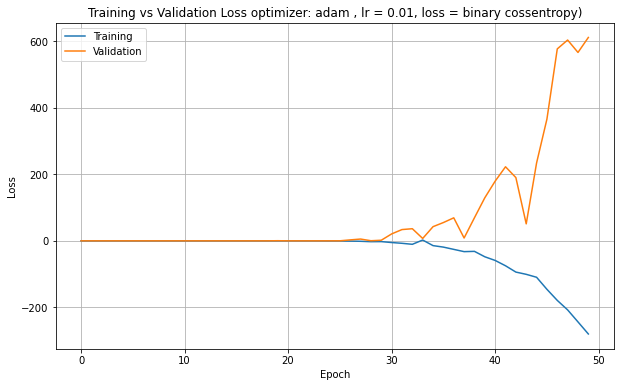

In [23]:
modelv1.plot_training()

In [24]:
#weighted neural network v2
class WNN_v2(KerasModel):

    def __init__(self, n_input):
        #model
        self.model = Sequential()
        #input
        self.model.add(Dense(128, input_dim = n_input, kernel_initializer='uniform',activation='relu'))
        #hidden layers
        self.model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
        self.model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
        self.model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
        #compile
        self.model.compile(optimizer=adagrad(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])

        #title
        self.title = 'optimizer: adagrad , lr = 0.01, loss = binary cossentropy)'

        #training
        self.training = None

In [25]:
modelv2 = WNN_v2(n_features)
modelv2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               1920      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 35,073
Trainable params: 35,073
Non-trainable params: 0
_________________________________________________________________


In [26]:
modelv2.fit(X_train_scaled, y_train, w_train, X_val_scaled, y_val, w_val, epochs)

Train on 9097 samples, validate on 3033 samples
Epoch 1/50
9097/9097 [==============================] - 1s 58us/step - loss: 0.0012 - accuracy: 0.8304 - val_loss: 0.0011 - val_accuracy: 0.8378
Epoch 2/50
9097/9097 [==============================] - 0s 49us/step - loss: 0.0010 - accuracy: 0.8519 - val_loss: 0.0011 - val_accuracy: 0.8721
Epoch 3/50
9097/9097 [==============================] - 0s 48us/step - loss: 9.3519e-04 - accuracy: 0.8605 - val_loss: 9.8012e-04 - val_accuracy: 0.8572
Epoch 4/50
9097/9097 [==============================] - 0s 44us/step - loss: 8.4701e-04 - accuracy: 0.8528 - val_loss: 9.8366e-04 - val_accuracy: 0.8602
Epoch 5/50
9097/9097 [==============================] - 0s 43us/step - loss: 7.4639e-04 - accuracy: 0.8656 - val_loss: 9.9040e-04 - val_accuracy: 0.8737
Epoch 6/50
9097/9097 [==============================] - 0s 44us/step - loss: 6.2591e-04 - accuracy: 0.8775 - val_loss: 7.7986e-04 - val_accuracy: 0.8625
Epoch 7/50
9097/9097 [============================

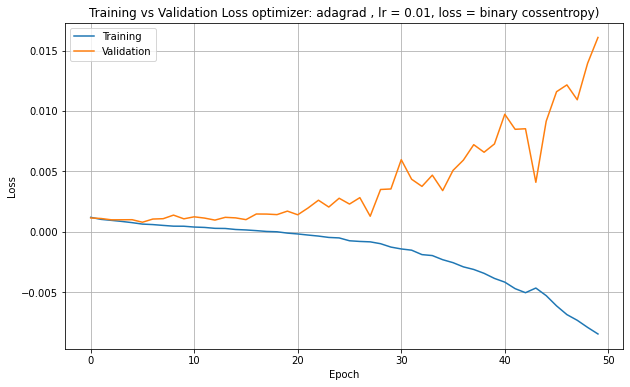

In [27]:
modelv2.plot_training()

In [28]:
#weighted neural network v1
class WNN_v3(KerasModel):

    def __init__(self, n_input):
        #model
        self.model = Sequential()
        #input
        self.model.add(Dense(64, input_dim = n_input, kernel_initializer='uniform',activation='softplus'))
        #hidden layers
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(128, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(256, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(128, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(64, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(1, kernel_initializer='he_uniform', activation='sigmoid'))
        #compile
        self.model.compile(optimizer=adadelta(lr=0.01), loss='binary_crossentropy')

        #title
        self.title = 'optimizer: adam , lr = 0.01, loss = binary cossentropy'

        #training
        self.training = None

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 64)                960       
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)              

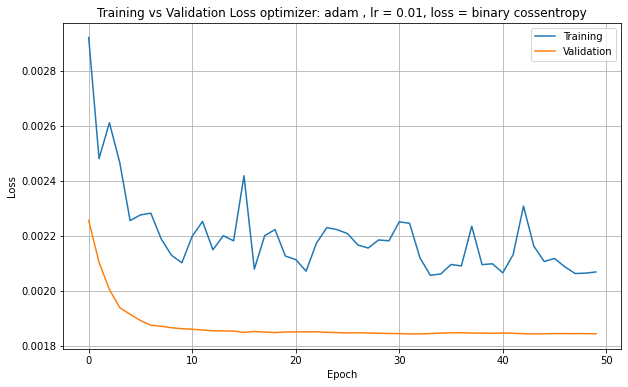

In [44]:
modelv3 = WNN_v3(n_features)
modelv3.summary()
modelv3.fit(X_train_scaled, y_train, w_train, X_val_scaled, y_val, w_val, epochs)
modelv3.plot_training()

=] - 1s 100us/step - loss: 0.0024 - val_loss: 0.0018
Epoch 13/200
9097/9097 [==============================] - 1s 96us/step - loss: 0.0024 - val_loss: 0.0019
Epoch 14/200
9097/9097 [==============================] - 1s 94us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 15/200
9097/9097 [==============================] - 1s 99us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 16/200
9097/9097 [==============================] - 1s 99us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 17/200
9097/9097 [==============================] - 1s 93us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 18/200
9097/9097 [==============================] - 1s 103us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 19/200
9097/9097 [==============================] - 1s 94us/step - loss: 0.0024 - val_loss: 0.0019
Epoch 20/200
9097/9097 [==============================] - 1s 98us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 21/200
9097/9097 [==============================] - 1s 101us/step - loss: 0.0023 - val_loss: 0.0019


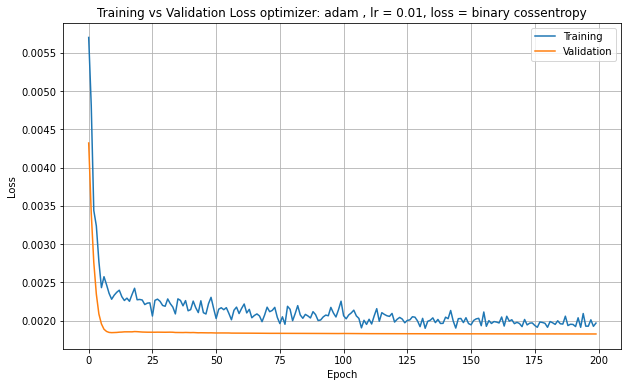

In [46]:
modelv32 = WNN_v3(n_features)
modelv32.summary()
modelv32.fit(X_train_scaled, y_train, w_train, X_val_scaled, y_val, w_val, 200)
modelv32.plot_training()

 313/500
9097/9097 [==============================] - 1s 91us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 314/500
9097/9097 [==============================] - 1s 91us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 315/500
9097/9097 [==============================] - 1s 91us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 316/500
9097/9097 [==============================] - 1s 90us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 317/500
9097/9097 [==============================] - 1s 93us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 318/500
9097/9097 [==============================] - 1s 96us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 319/500
9097/9097 [==============================] - 1s 89us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 320/500
9097/9097 [==============================] - 1s 91us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 321/500
9097/9097 [==============================] - 1s 94us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 322/500
9097/9097 [==========================

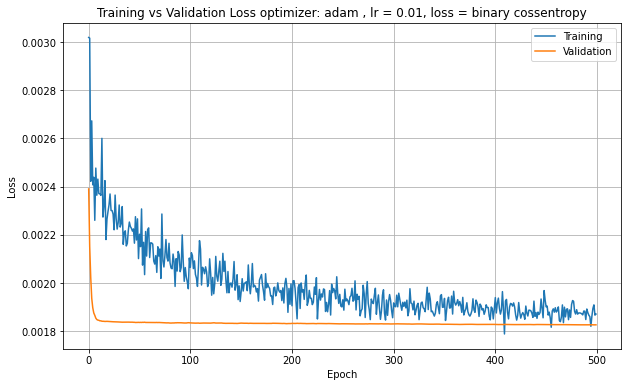

In [48]:
modelv33 = WNN_v3(n_features)
modelv33.summary()
modelv33.fit(X_train_scaled, y_train, w_train, X_val_scaled, y_val, w_val, 500)
modelv33.plot_training()

In [49]:
# serialize model to JSON
model_json = modelv33.model.to_json()
with open("../processed_data/model33.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
modelv33.model.save_weights("../processed_data/model33.h5")
print("Saved model to disk")

Saved model to disk


In [83]:
# load json and create model
json_file = open("../processed_data/model33.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_modelv33 = model_from_json(loaded_model_json)
loaded_modelv33.load_weights("../processed_data/model33.h5")
loaded_modelv33.compile(loss='binary_crossentropy', optimizer=adam(lr=0.01))

In [54]:
y_test.shape

(3033, 1)

In [78]:
y_pred_prob = loaded_modelv33.predict(X_test)
y_pred = (y_pred_prob>=0.1)
y_pred.shape

(3033, 1)

In [85]:
print(classification_report(y_test, y_pred, sample_weight = w_test))

precision    recall  f1-score   support

           0       0.63      0.77      0.69 6.084247619448123
           1       0.22      0.13      0.16 3.1096750530852217

    accuracy                           0.55 9.193922672533345
   macro avg       0.43      0.45      0.43 9.193922672533345
weighted avg       0.49      0.55      0.51 9.193922672533345



In [81]:
confusion_matrix(y_test, y_pred, sample_weight = w_test)

array([[4.65773862, 1.426509  ],
       [2.70548674, 0.40418831]])